In [12]:
%matplotlib inline
%env THEANO_FLAGS=device=cpu,floatX=float32
import theano

import pymc3 as pm
from pymc3 import Normal, Metropolis, sample, MvNormal, Dirichlet, \
    DensityDist, find_MAP, NUTS, Slice
import theano.tensor as tt
from theano.tensor.nlinalg import det
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize


env: THEANO_FLAGS=device=cpu,floatX=float32


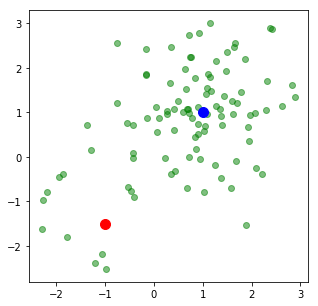

In [2]:


n_samples = 100
rng = np.random.RandomState(145)
ms = np.array([[-1, -1.5], [1, 1]])
ps = np.array([0.2, 0.8])

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples)
      for z, m in zip(zs, ms)]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)

In [3]:
from pymc3.math import logsumexp

# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value)
                 for i, mu in enumerate(mus)]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i,
                    mu=pm.floatX(np.zeros(2)),
                    tau=pm.floatX(0.1 * np.eye(2)),
                    shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)

# MCMC to compare

In [16]:
 
map_estimate = pm.find_MAP(model=model, fmin=optimize.fmin_powell)
with model:

    # obtain starting values via MAP
    start =  find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step =  Slice()

    # draw 5000 posterior samples
    traces =  sample(500,njobs=1,start=start)

 

/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/tuning/starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -320.51:   4%|▎         | 177/5000 [00:00<00:04, 1008.46it/s]


Optimization terminated successfully.
         Current function value: 320.505287
         Iterations: 2
         Function evaluations: 177


logp = -320.51:   4%|▎         | 177/5000 [00:00<00:04, 1083.24it/s]


Optimization terminated successfully.
         Current function value: 320.505287
         Iterations: 2
         Function evaluations: 177


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [pi_stickbreaking__, mu_1, mu_0]
100%|██████████| 1000/1000 [00:03<00:00, 254.51it/s]
The acceptance probability does not match the target. It is 0.8877163847491201, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


(-6, 6)

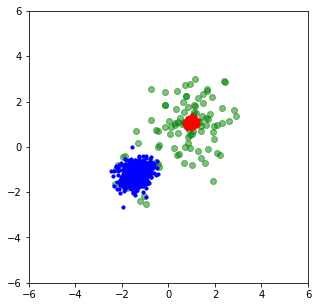

In [17]:

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
mu_0, mu_1 = trace['mu_0'], trace['mu_1']
plt.scatter(mu_0[-500:, 0], mu_0[-500:, 1], c="r", s=10)
plt.scatter(mu_1[-500:, 0], mu_1[-500:, 1], c="b", s=10)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

# ADVI

In [18]:
with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)

with model:
    %time approx = pm.fit(n=4500, obj_optimizer=pm.adagrad(learning_rate=1e-1))

means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov)**.5)

Average Loss = 312.03: 100%|██████████| 4500/4500 [00:02<00:00, 1616.63it/s]
Finished [100%]: Average Loss = 312.03


CPU times: user 5.34 s, sys: 282 ms, total: 5.62 s
Wall time: 5.16 s


In [ ]:
from copy import deepcopy

mu_0, sd_0 = means['mu_0'], sds['mu_0']
mu_1, sd_1 = means['mu_1'], sds['mu_1']

def logp_normal_np(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * np.log(2 * np.pi) + np.log(1./np.linalg.det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

def threshold(zz):
    zz_ = deepcopy(zz)
    zz_[zz < np.max(zz) * 1e-2] = None
    return zz_

def plot_logp_normal(ax, mu, sd, cmap):
    f = lambda value: np.exp(logp_normal_np(mu, np.diag(1 / sd**2), value))
    g = lambda mu, sd: np.arange(mu - 3, mu + 3, .1)
    xx, yy = np.meshgrid(g(mu[0], sd[0]), g(mu[1], sd[1]))
    zz = f(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).reshape(xx.shape)
    ax.contourf(xx, yy, threshold(zz), cmap=cmap, alpha=0.9)

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
plot_logp_normal(ax, mu_0, sd_0, cmap='Reds')
plot_logp_normal(ax, mu_1, sd_1, cmap='Blues')
plt.xlim(-6, 6)
plt.ylim(-6, 6)

# VERY LARGE DATASET

(-6, 6)

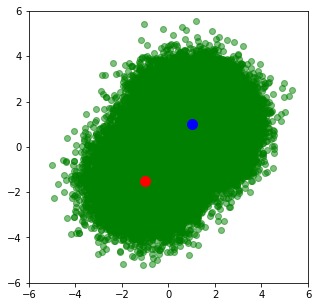

In [20]:
n_samples = 100000

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples)
      for z, m in zip(zs, ms)]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

In [21]:
map_estimate = pm.find_MAP(model=model, fmin=optimize.fmin_powell)

with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)

    # obtain starting values via MAP
    start =  find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = pm.NUTS(scaling=start)

    # draw 5000 posterior samples
    traces = pm.sample(1000, step, start=start, progressbar=True,njobs=1)

/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/tuning/starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -320.51:   4%|▎         | 177/5000 [00:00<00:04, 1118.05it/s]


Optimization terminated successfully.
         Current function value: 320.505287
         Iterations: 2
         Function evaluations: 177


logp = -3.6508e+05:   4%|▍         | 188/5000 [00:01<00:48, 99.89it/s] 


Optimization terminated successfully.
         Current function value: 365082.748181
         Iterations: 3
         Function evaluations: 188


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [pi_stickbreaking__, mu_1, mu_0]
 20%|██        | 200/1000 [13:53<55:33,  4.17s/it]/home/nilavro/irleak/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

Tuning was enabled throughout the whole trace.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [22]:
minibatch_size = 200
# In memory Minibatches for better speed
data_t = pm.Minibatch(data, minibatch_size)

with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data_t, total_size=len(data))

In [23]:
def f():
    approx = pm.fit(n=1500, obj_optimizer=pm.adagrad(learning_rate=1e-1), model=model)
    means = approx.bij.rmap(approx.mean.eval())
    sds = approx.bij.rmap(approx.std.eval())
    return means, sds, approx.hist

%time means, sds, elbos = f()

Average Loss = 3.2752e+05: 100%|██████████| 1500/1500 [00:01<00:00, 1376.06it/s]
Finished [100%]: Average Loss = 3.2744e+05


CPU times: user 3.8 s, sys: 309 ms, total: 4.11 s
Wall time: 8.7 s


(-6, 6)

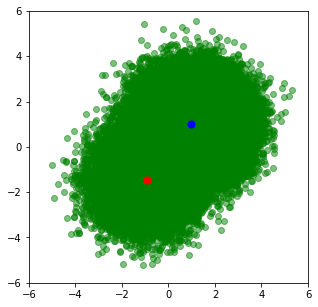

In [24]:
from copy import deepcopy

mu_0, sd_0 = means['mu_0'], sds['mu_0']
mu_1, sd_1 = means['mu_1'], sds['mu_1']

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
plt.scatter(mu_0[0], mu_0[1], c="r", s=50)
plt.scatter(mu_1[0], mu_1[1], c="b", s=50)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

# Try on my own 

In [50]:

basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    w = pm.Dirichlet('w',  np.array([1., 1. ]))
    mu = pm.Normal('mu', mu=0, sd = 5, shape = 2)
    sigma =  pm.Gamma('sigma', alpha = 1., beta =1., shape = 2) 
     
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.NormalMixture('Y_obs', w = w , mu=mu, sd = sigma, observed=data) 

In [51]:
with basic_model:
        # obtain starting values via MAP
    start =  find_MAP(method="L-BFGS-B")

    # instantiate sampler
    step = pm.NUTS(scaling=start)
    traces = pm.sample(1000, step, start=start, progressbar=True,njobs=1)

logp = -1.5854e+05, ||grad|| = 0.32892: 100%|██████████| 51/51 [00:01<00:00, 47.49it/s]  
/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, mu, w_stickbreaking__]
100%|██████████| 1500/1500 [02:57<00:00,  8.47it/s]


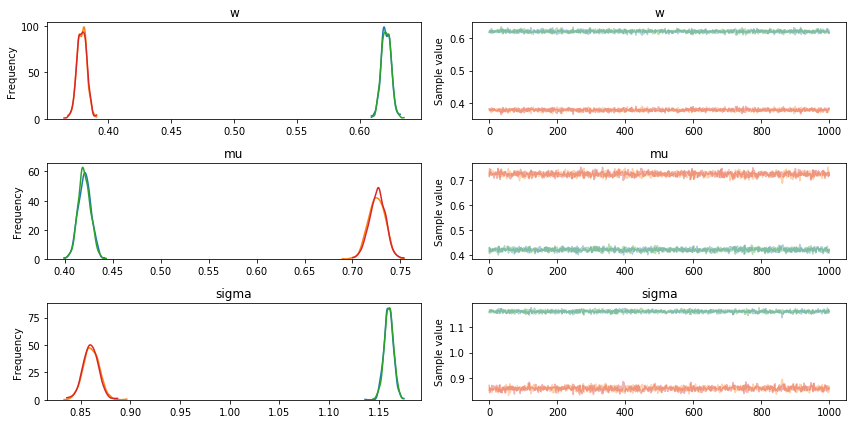

In [53]:
pm.traceplot(traces, varnames=['w', 'mu', 'sigma']);


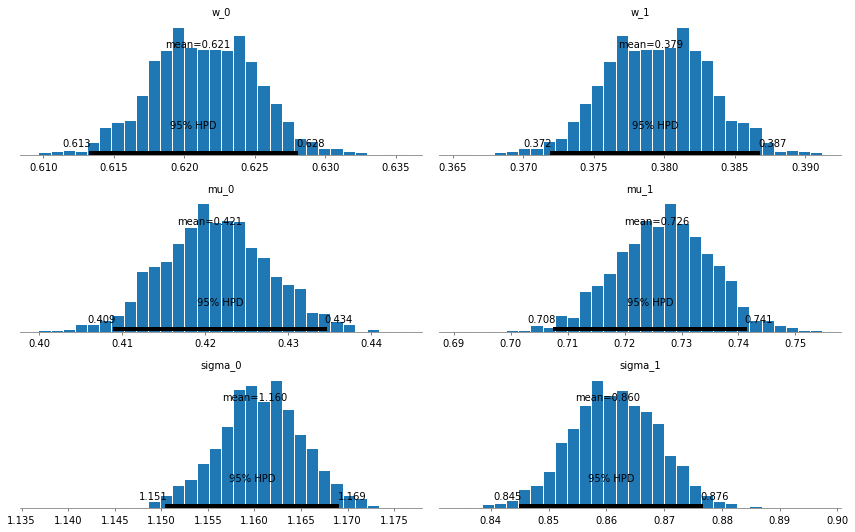

In [54]:
pm.plot_posterior(traces, varnames=['w', 'mu', 'sigma']);


In [61]:
with model:
    %time approx = pm.fit(n=20000, obj_optimizer=pm.adagrad(learning_rate=1e-1))

means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov)**.5)

Average Loss = 3.2355e+05: 100%|██████████| 20000/20000 [00:16<00:00, 1208.57it/s]
Finished [100%]: Average Loss = 3.2359e+05


CPU times: user 19.4 s, sys: 1.38 s, total: 20.7 s
Wall time: 18.7 s


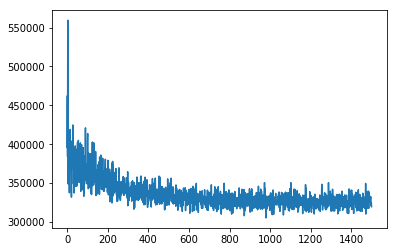

In [62]:
plt.plot(elbos);
 

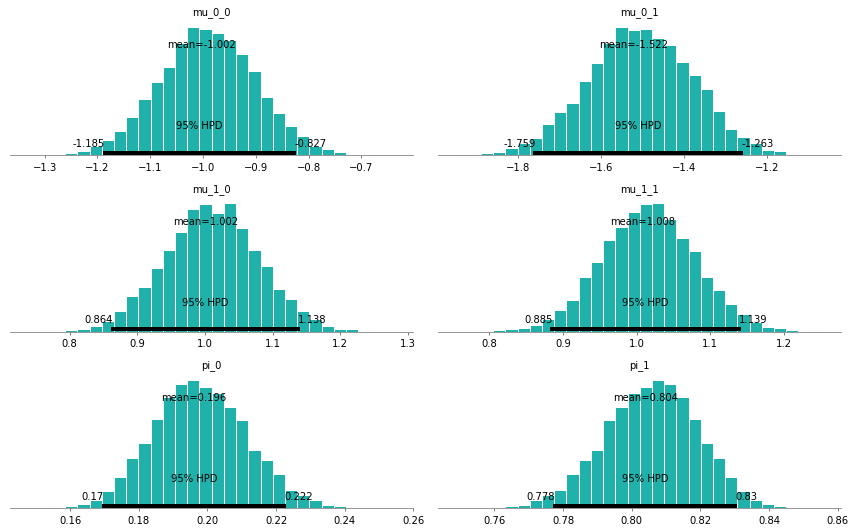

In [58]:
pm.plot_posterior(approx.sample(10000), color='LightSeaGreen');
